In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=(7, 13), stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=2, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

#         self.conv3 = nn.Conv2d(16, 64, kernel_size=4, stride=2, padding=1)
#         self.bn3 = nn.BatchNorm2d(64)

#         self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1)
#         self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=2, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=(7, 13), stride=1, padding=2) 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
        
#         e1 = self.bn1(self.conv1(input))
#         e2 = self.bn2(self.conv2(e1))
#         e3 = self.bn3(self.conv3(e2))
        
#         e4 = self.bn4(self.conv4(e3))
#         e5 = self.bn5(self.conv5(e4))
#         e6 = self.conv6(e5)

#         return e6
#         print(input.shape)
#         m, indices = self.maxpool(input)
#         um = self.unpool(m, indices)
    
        e1 = self.conv1(input)
        bn1 = self.bn1(self.act(e1))
#         print(bn1.shape)
        
#         print(m3.shape)
        
#         print(um.shape)
#         print(bn1.shape)
        e2 = self.bn2(self.conv2(bn1))
#         print(e2.shape)
#         m3, indices =self.maxpool(bn1)
#         um = self.unpool(m3, indices)
        
        
#         
#         e5 = self.bn5(self.conv5(e2))
        e5 = self.bn5(self.conv5(e2))
#         print(e5.shape)
        e6 = self.conv6(e5)
#         print(e6.shape)

        return e6



In [3]:
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test

model = Net()
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.5)

num_folds = 5
fold_num = 0
origin_train, origin_test = get_train_test(3, num_folds=num_folds, fold_num=fold_num)

train_residual = origin_train[:, 1:6, :, :].sum(axis=1).reshape(-1, 1, 112, 24).copy()
train = np.hstack((origin_train, train_residual))

# create the residual column
test_residual = origin_test[:, 1:6, :, :].sum(axis=1).reshape(-1, 1, 112, 24).copy()
test = np.hstack((origin_test, test_residual))

APPLIANCE_ORDER=['aggregate', 'hvac', 'fridge', 'dr', 'dw', 'mw', 'residual']

valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()

train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
print(train_aggregate.shape)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

(43, 1, 112, 24)


In [4]:
def reg_loss(pred, out):
    l1_loss = torch.sum(torch.abs(pred-out))  
    reg = 0.5*torch.sum(torch.abs(out))
    return l1_loss + reg

In [5]:
torch.cuda.device(2)
print(torch.cuda.current_device())

0


In [12]:
model = Net()

loss_fn = nn.L1Loss()
# loss_fun = reg_loss
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True
if cuda_av:
    model = model.cuda()
    loss_fn = loss_fn.cuda()
app_idx = APPLIANCE_ORDER.index('residual') 
print(app_idx)
    
inp = Variable(torch.Tensor(train_aggregate))
out = Variable(torch.Tensor(train[:, app_idx, :, :].reshape(train.shape[0], 1, train.shape[2], -1)))
test_inp = Variable(torch.Tensor(test_aggregate))
test_out = Variable(torch.Tensor(test[:, app_idx, :, :].reshape(test.shape[0], 1, test.shape[2], -1)))
if cuda_av:
    inp = inp.cuda()
    out = out.cuda()
    test_inp = test_inp.cuda()
    test_out = test_out.cuda()

6


In [13]:

for epoch in range(20000):
    
    pred = model(inp)
#     print(pred.shape)
#     pred = torch.clamp(pred, min=0.)
    loss = loss_fn(pred, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch %100 == 0:
        
        
        test_pr = model(test_inp)
        test_pr = torch.clamp(test_pr, min=0.)
        test_loss = loss_fn(test_pr, test_out)
        
        print(epoch, "Training Error:", loss.data[0], "Test Error:", test_loss.data[0])
#         print(test_pr.max())

0 Training Error: 1107.8978271484375 Test Error: 942.8275146484375
100 Training Error: 486.1466064453125 Test Error: 405.4329833984375
200 Training Error: 390.52471923828125 Test Error: 343.2170104980469
300 Training Error: 334.6629333496094 Test Error: 326.2454833984375
400 Training Error: 300.0711364746094 Test Error: 314.15704345703125
500 Training Error: 287.0986022949219 Test Error: 311.22991943359375
600 Training Error: 287.3448486328125 Test Error: 307.1190185546875
700 Training Error: 280.5995788574219 Test Error: 308.8798828125
800 Training Error: 276.2411193847656 Test Error: 313.7276916503906
900 Training Error: 279.31500244140625 Test Error: 310.1986999511719
1000 Training Error: 273.6990966796875 Test Error: 309.31488037109375
1100 Training Error: 268.1596984863281 Test Error: 310.27813720703125
1200 Training Error: 266.583740234375 Test Error: 307.2413024902344
1300 Training Error: 261.3802490234375 Test Error: 319.61846923828125
1400 Training Error: 258.3761291503906 Tes

11800 Training Error: 222.97378540039062 Test Error: 336.09912109375
11900 Training Error: 224.93618774414062 Test Error: 331.967041015625
12000 Training Error: 227.4358673095703 Test Error: 338.3962707519531
12100 Training Error: 224.01226806640625 Test Error: 341.9908752441406
12200 Training Error: 225.27622985839844 Test Error: 336.6910095214844
12300 Training Error: 223.32200622558594 Test Error: 338.9515075683594
12400 Training Error: 225.95819091796875 Test Error: 335.643310546875
12500 Training Error: 222.24925231933594 Test Error: 335.3491516113281
12600 Training Error: 224.399169921875 Test Error: 331.1465148925781
12700 Training Error: 226.1151885986328 Test Error: 337.8048095703125
12800 Training Error: 225.00376892089844 Test Error: 333.71014404296875
12900 Training Error: 224.16110229492188 Test Error: 336.30950927734375
13000 Training Error: 224.7048797607422 Test Error: 335.1830749511719
13100 Training Error: 221.60397338867188 Test Error: 336.5554504394531
13200 Trainin

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [15]:
test_pr = torch.clamp(test_pr, min=0.)
pred = torch.clamp(pred, min=0.)

In [16]:
test[:, 6, :, :].shape

(14, 112, 24)

14


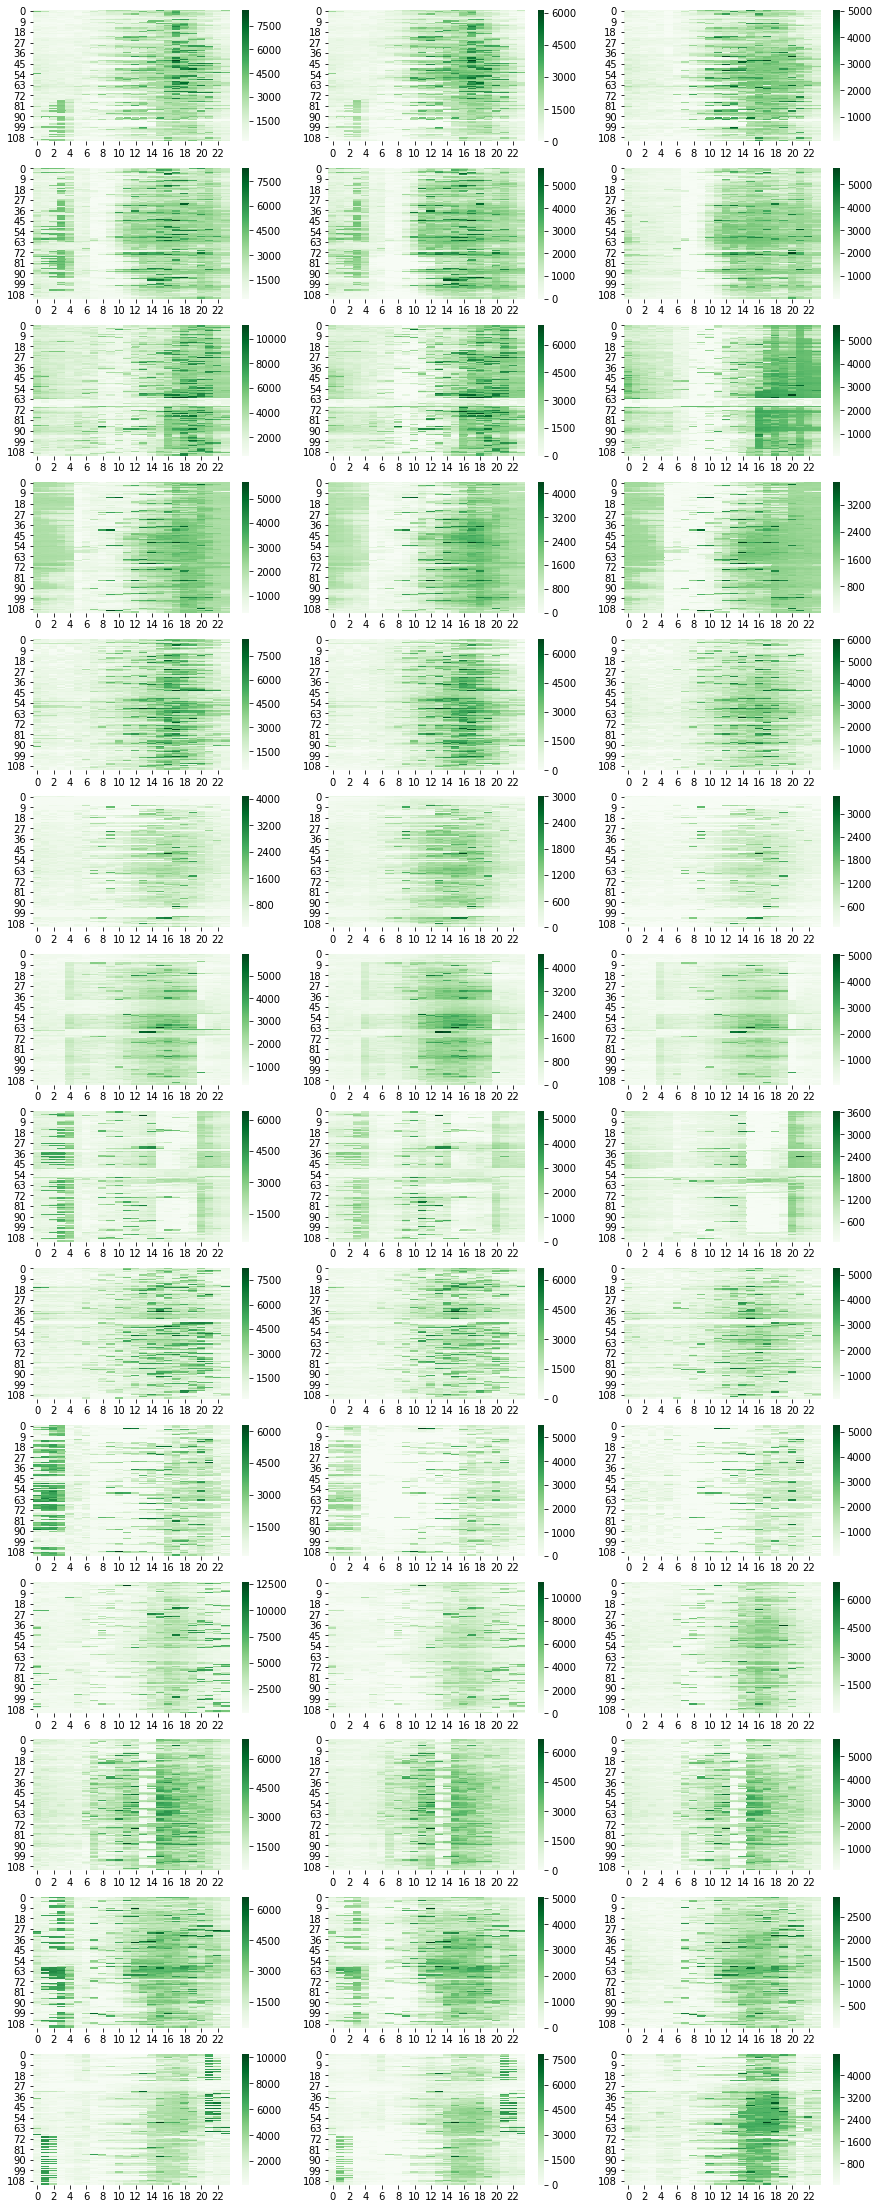

In [17]:
num_test = test_pr.cpu().data.numpy().shape[0]
print(num_test)
fig, axes = plt.subplots(nrows=num_test,ncols=3, figsize=(15, 40))
# ax = axes.flatten()

# pred = test_pr.cpu().data.numpy()
# print(pred.shape)
# print(pred[0][0].shape)


for i in range(num_test):
    sns.heatmap(pd.DataFrame(test_inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0])
    sns.heatmap(pd.DataFrame(test_pr.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 1])
    sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])




In [ ]:
num_train = pred.cpu().data.numpy().shape[0]
num_test = pred.cpu().data.numpy().shape[0]
print(num_test)
fig, axes = plt.subplots(nrows=9,ncols=3, figsize=(15, 20))
# ax = axes.flatten()

# pred = test_pr.cpu().data.numpy()
# print(pred.shape)
# print(pred[0][0].shape)



for i in range(num_train):
    sns.heatmap(pd.DataFrame(inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0], vmin=0, vmax=10000)
    sns.heatmap(pd.DataFrame(pred.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 1])
    sns.heatmap(pd.DataFrame(out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])




43


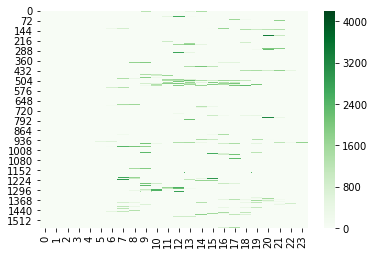

In [388]:
sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy().reshape(-1, 24)), cmap='Greens')